In [1]:
import csv
from nltk.stem.snowball import SnowballStemmer
import nltk
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import json
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
import matplotlib.pyplot as plt
import pickle
from joblib import dump
import networkx as nx
import random
import pandas as pd


nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))
# initialize lemmatizer
lemmatizer = WordNetLemmatizer()

#frequent mitre words
freq_mitre_words = ['domain', 'api', 'web', 'password', 'script', 'program', 'registry', 'exe', 'traffic', 'key', 'protocol', 'device', 'log', 'cloud', 'gather', 'persistence', 'malware', 'binary', 'directory', 'security', 'search', 'authentication', 'privilege', 'compromise', 'email', 'infrastructure', 'utility', 'legitimate', 'host', 'certificate', 'permission', 'modify', 'discovery', 'argument', 'time', 'organization', 'perform', 'powershell', 'operating', 'connection', 'abuse', 'call', 'function', 'compromised', 'content', 'executed', 'image', 'local', 'set', 'name']

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ktouloumis\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [2]:
def get_top_n_words(corpus, n=None):
    # receives a list of sentences
    # the most frequent words with their number of appearances
    vec = CountVectorizer(max_df=0.2).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

In [3]:
def preprocessDesc(desc):
    punc = '''!()-[]{};:'"\, <>./?@#$%^&*_~\\'''
    lemmatizer = WordNetLemmatizer()
    word_tokens = word_tokenize(desc)
    
    filtered_sentence = [lemmatizer.lemmatize(w.lower()) for w in word_tokens if
                         w.lower() not in en_stop and w.lower() not in freq_mitre_words and w not in punc]
    res = [x for x in filtered_sentence if not any(map(str.isdigit, x)) and '\\' not in x and '/' not in x and '-' not in x and x not in freq_mitre_words]
    return res

In [4]:
# function for printing cluster centroids
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        # print("\nTopic #%d:" % topic_idx)
        topici = " ".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        topics[topic_idx] = topici

    with open('lda-topics.txt', 'w') as outfile:
        json.dump(topics, outfile)

In [5]:
df = pd.read_excel('enterprise-attack-v9.0-techniques.xlsx') #,index_col=0

dfids = df['ID'].tolist()
dfdetect = df['detection'].tolist()
dfname = df['name'].tolist()
dfdesc = df['description'].tolist()

stem_ls=[]

for name, desc, det in zip(dfname, dfdesc, dfdetect):
    toks = preprocessDesc(name+desc+det)
    print("toks=", toks)
    fullstring = ' '.join(toks)
    stem_ls.append(fullstring)


toks= ['elevation', 'control', 'mechanismadversaries', 'may', 'circumvent', 'mechanism', 'designed', 'control', 'elevate', 'gain', 'modern', 'system', 'contain', 'native', 'elevation', 'control', 'mechanism', 'intended', 'limit', 'user', 'machine', 'authorization', 'granted', 'specific', 'user', 'order', 'task', 'considered', 'higher', 'risk', 'adversary', 'several', 'method', 'take', 'advantage', 'control', 'mechanism', 'order', 'escalate', 'system.monitor', 'file', 'system', 'file', 'setuid', 'setgid', 'bit', 'also', 'look', 'process', 'behavior', 'may', 'indicative', 'process', 'injection', 'http', 'unusual', 'loaded', 'dlls', 'dll', 'order', 'hijacking', 'http', 'indicate', 'attempt', 'gain', 'access', 'higher', 'privileged', 'process', 'linux', 'auditd', 'alert', 'every', 'user', "'s", 'actual', 'id', 'effective', 'id', 'different', 'happens', 'sudo', 'consider', 'monitoring', 'code', 'execution', 'may', 'indicate', 'authorizationexecutewithprivileges', 'macos', 'system', 'may', '

toks= ['active', 'scanning', 'vulnerability', 'scanningadversaries', 'may', 'scan', 'victim', 'vulnerability', 'used', 'targeting', 'vulnerability', 'scan', 'typically', 'check', 'configuration', 'target', 'ex', 'software', 'version', 'potentially', 'aligns', 'target', 'specific', 'exploit', 'adversary', 'may', 'seek', 'use', 'scan', 'may', 'also', 'include', 'broad', 'attempt', 'victim', 'information', 'http', 'used', 'identify', 'commonly', 'known', 'exploitable', 'vulnerability', 'vulnerability', 'scan', 'typically', 'harvest', 'running', 'software', 'version', 'number', 'via', 'server', 'banner', 'listening', 'port', 'network', 'artifact', 'citation', 'owasp', 'vuln', 'scanning', 'information', 'scan', 'may', 'reveal', 'opportunity', 'form', 'reconnaissance', 'ex', 'open', 'http', 'open', 'technical', 'database', 'http', 'establishing', 'operational', 'resource', 'ex', 'develop', 'capability', 'http', 'obtain', 'capability', 'http', 'initial', 'access', 'ex', 'exploit', 'applicatio

toks= ['boot', 'logon', 'initialization', 'rc', 'scriptsadversaries', 'may', 'establish', 'modifying', 'rc', 'system', '’', 'startup', 'file', 'allow', 'system', 'administrator', 'map', 'start', 'custom', 'service', 'startup', 'different', 'run', 'level', 'rc', 'require', 'root', 'adversary', 'establish', 'adding', 'malicious', 'path', 'shell', 'command', 'code', 'rc.local', 'code', 'rc.common', 'rc', 'specific', 'distribution', 'citation', 'iranthreats', 'kitten', 'dec', 'citation', 'intezer', 'hiddenwasp', 'map', 'upon', 'reboot', 'system', 'executes', "'s", 'root', 'resulting', 'adversary', 'rc', 'especially', 'effective', 'lightweight', 'distribution', 'using', 'root', 'user', 'default', 'iot', 'embedded', 'system', 'citation', 'several', 'system', 'moved', 'systemd', 'deprecated', 'use', 'rc', 'deprecated', 'mechanism', 'macos', 'favor', 'launchd', 'http', 'citation', 'apple', 'developer', 'doco', 'archive', 'launchd', 'citation', 'startup', 'item', 'technique', 'used', 'mac', 'o'

toks= ['container', 'administration', 'commandadversaries', 'may', 'container', 'administration', 'service', 'execute', 'command', 'within', 'container', 'container', 'administration', 'service', 'docker', 'daemon', 'kubernetes', 'server', 'kubelet', 'may', 'allow', 'remote', 'management', 'container', 'within', 'environment', 'citation', 'docker', 'daemon', 'cli', 'citation', 'kubernetes', 'citation', 'kubernetes', 'kubelet', 'docker', 'adversary', 'may', 'specify', 'entrypoint', 'container', 'deployment', 'executes', 'command', 'may', 'use', 'command', 'code', 'docker', 'exec', 'execute', 'command', 'within', 'running', 'container', 'citation', 'docker', 'entrypoint', 'citation', 'docker', 'exec', 'kubernetes', 'adversary', 'sufficient', 'may', 'gain', 'remote', 'execution', 'container', 'cluster', 'via', 'interaction', 'kubernetes', 'server', 'kubelet', 'running', 'command', 'code', 'kubectl', 'exec', 'citation', 'kubectl', 'exec', 'get', 'shell', 'container', 'administration', 'ser

toks= ['data', 'stagedadversaries', 'may', 'stage', 'collected', 'data', 'central', 'location', 'prior', 'exfiltration', 'data', 'may', 'kept', 'separate', 'file', 'combined', 'one', 'file', 'technique', 'archive', 'collected', 'data', 'http', 'interactive', 'command', 'shell', 'may', 'used', 'common', 'functionality', 'within', 'cmd', 'http', 'bash', 'may', 'used', 'copy', 'data', 'staging', 'location', 'citation', 'pwc', 'hopper', 'april', 'environment', 'adversary', 'may', 'stage', 'data', 'within', 'particular', 'instance', 'virtual', 'machine', 'exfiltration', 'adversary', 'may', 'create', 'instance', 'http', 'stage', 'data', 'instance', 'citation', 'mandiant', 'adversary', 'may', 'choose', 'stage', 'data', 'victim', 'network', 'centralized', 'location', 'prior', 'exfiltration', 'minimize', 'number', 'made', 'server', 'better', 'evade', 'detection.processes', 'appear', 'reading', 'file', 'disparate', 'location', 'writing', 'file', 'may', 'indication', 'data', 'staged', 'especially

toks= ['disk', 'wipe', 'disk', 'wipeadversaries', 'may', 'erase', 'storage', 'specific', 'system', 'large', 'number', 'network', 'interrupt', 'availability', 'system', 'network', 'resource', 'adversary', 'may', 'partially', 'completely', 'overwrite', 'storage', 'rendering', 'data', 'irrecoverable', 'storage', 'interface', 'citation', 'novetta', 'blockbuster', 'citation', 'novetta', 'blockbuster', 'destructive', 'citation', 'doj', 'lazarus', 'sony', 'instead', 'wiping', 'specific', 'disk', 'structure', 'file', 'adversary', 'destructive', 'intent', 'may', 'wipe', 'arbitrary', 'portion', 'disk', 'wipe', 'disk', 'adversary', 'may', 'acquire', 'direct', 'access', 'hard', 'drive', 'order', 'overwrite', 'arbitrarily', 'sized', 'portion', 'disk', 'random', 'data', 'citation', 'novetta', 'blockbuster', 'destructive', 'adversary', 'observed', 'leveraging', 'driver', 'like', 'rawdisk', 'http', 'directly', 'access', 'disk', 'citation', 'novetta', 'blockbuster', 'citation', 'novetta', 'blockbuster'

toks= ['event', 'triggered', 'execution', 'application', 'shimmingadversaries', 'may', 'establish', 'elevate', 'executing', 'malicious', 'triggered', 'application', 'shim', 'microsoft', 'window', 'application', 'compatibility', 'application', 'shim', 'created', 'allow', 'backward', 'compatibility', 'software', 'system', 'codebase', 'change', 'example', 'application', 'shimming', 'feature', 'allows', 'developer', 'apply', 'fix', 'application', 'without', 'rewriting', 'code', 'created', 'window', 'xp', 'work', 'window', 'citation', 'elastic', 'process', 'injection', 'july', 'within', 'framework', 'shim', 'created', 'act', 'buffer', 'specifically', 'import', 'address', 'table', 'window', 'o', 'shim', 'cache', 'referenced', 'determine', 'requires', 'use', 'shim', 'database', '.sdb', 'shim', 'database', 'us', 'hooking', 'redirect', 'code', 'necessary', 'order', 'communicate', 'o', 'list', 'shim', 'currently', 'installed', 'default', 'window', 'installer', 'sdbinst.exe', 'kept', 'code', 'win

toks= ['exploitation', 'credential', 'accessadversaries', 'may', 'exploit', 'software', 'vulnerability', 'attempt', 'collect', 'credential', 'exploitation', 'software', 'vulnerability', 'occurs', 'adversary', 'take', 'advantage', 'programming', 'error', 'service', 'within', 'system', 'software', 'kernel', 'execute', 'code', 'credentialing', 'mechanism', 'may', 'targeted', 'exploitation', 'adversary', 'mean', 'gain', 'access', 'useful', 'credential', 'circumvent', 'process', 'gain', 'access', 'system', 'one', 'example', 'target', 'kerberos', 'used', 'forge', 'kerberos', 'ticket', 'using', 'user', 'citation', 'technet', 'citation', 'adsecurity', 'detecting', 'forged', 'ticket', 'exploitation', 'credential', 'access', 'may', 'also', 'result', 'escalation', 'depending', 'process', 'targeted', 'credential', 'obtained.detecting', 'software', 'exploitation', 'may', 'difficult', 'depending', 'tool', 'available', 'software', 'exploit', 'may', 'always', 'succeed', 'may', 'cause', 'exploited', 'p

toks= ['victim', 'identity', 'informationadversaries', 'may', 'information', 'victim', "'s", 'identity', 'used', 'targeting', 'information', 'identity', 'may', 'include', 'variety', 'detail', 'including', 'personal', 'data', 'ex', 'employee', 'address', 'etc', 'well', 'sensitive', 'detail', 'credential', 'adversary', 'may', 'information', 'various', 'way', 'direct', 'elicitation', 'via', 'phishing', 'information', 'http', 'information', 'victim', 'may', 'also', 'exposed', 'adversary', 'via', 'online', 'accessible', 'data', 'ex', 'social', 'medium', 'http', 'website', 'http', 'citation', 'opm', 'leak', 'citation', 'register', 'deloitte', 'citation', 'register', 'uber', 'citation', 'detectify', 'slack', 'token', 'citation', 'forbes', 'github', 'cred', 'citation', 'github', 'trufflehog', 'citation', 'github', 'gitrob', 'citation', 'cnet', 'leak', 'gathering', 'information', 'may', 'reveal', 'opportunity', 'form', 'reconnaissance', 'ex', 'open', 'http', 'phishing', 'information', 'http', '

toks= ['hijack', 'execution', 'flow', 'dll', 'order', 'hijackingadversaries', 'may', 'execute', 'malicious', 'payload', 'hijacking', 'order', 'used', 'load', 'dlls', 'window', 'system', 'use', 'common', 'method', 'look', 'required', 'dlls', 'load', 'citation', 'microsoft', 'dynamic', 'link', 'library', 'order', 'citation', 'fireeye', 'hijacking', 'july', 'hijacking', 'dll', 'load', 'may', 'purpose', 'establishing', 'well', 'elevating', 'evading', 'restriction', 'file', 'execution', 'many', 'way', 'adversary', 'hijack', 'dll', 'load', 'adversary', 'may', 'plant', 'trojan', 'library', 'file', 'dlls', 'searched', 'location', 'library', 'requested', 'causing', 'window', 'load', 'malicious', 'library', 'called', 'victim', 'adversary', 'may', 'also', 'dll', 'preloading', 'also', 'called', 'planting', 'attack', 'citation', 'owasp', 'planting', 'placing', 'malicious', 'dll', 'ambiguously', 'specified', 'dll', 'location', 'window', 'dll', 'often', 'location', 'current', 'working', 'citation', '

toks= ['internal', 'spearphishingadversaries', 'may', 'use', 'internal', 'spearphishing', 'gain', 'access', 'additional', 'information', 'exploit', 'user', 'within', 'already', 'access', 'account', 'system', 'within', 'environment', 'internal', 'spearphishing', 'attack', 'account', 'owned', 'either', 'controlling', 'user', "'s", 'previously', 'installed', 'compromising', 'account', 'credential', 'user', 'adversary', 'attempt', 'take', 'advantage', 'trusted', 'internal', 'account', 'increase', 'likelihood', 'tricking', 'target', 'falling', 'phish', 'attempt', 'citation', 'trend', 'micro', 'phishing', 'start', 'inside', 'adversary', 'may', 'leverage', 'spearphishing', 'attachment', 'http', 'spearphishing', 'link', 'http', 'part', 'internal', 'spearphishing', 'deliver', 'payload', 'redirect', 'external', 'site', 'capture', 'credential', 'input', 'capture', 'http', 'site', 'mimic', 'login', 'interface', 'notable', 'incident', 'internal', 'spearphishing', 'used', 'eye', 'pyramid', 'campaign

toks= ['network', 'denial', 'serviceadversaries', 'may', 'network', 'denial', 'service', 'do', 'attack', 'degrade', 'block', 'availability', 'targeted', 'resource', 'user', 'network', 'do', 'performed', 'exhausting', 'network', 'bandwidth', 'service', 'rely', 'example', 'resource', 'include', 'specific', 'website', 'service', 'dns', 'application', 'adversary', 'observed', 'conducting', 'network', 'do', 'attack', 'political', 'purpose', 'citation', 'fireeye', 'oppoisonedhandover', 'february', 'support', 'malicious', 'activity', 'including', 'distraction', 'citation', 'fsisac', 'fraudnetdos', 'september', 'hacktivism', 'extortion', 'citation', 'symantec', 'ddos', 'october', 'network', 'do', 'occur', 'bandwidth', 'capacity', 'network', 'system', 'exhausted', 'due', 'volume', 'malicious', 'directed', 'resource', 'network', 'network', 'resource', 'relies', 'example', 'adversary', 'may', 'send', 'server', 'hosted', 'network', 'internet', 'generated', 'single', 'system', 'multiple', 'system',

toks= ['office', 'application', 'startup', 'office', 'testadversaries', 'may', 'microsoft', 'office', '``', 'office', 'test', "''", 'obtain', 'system', 'office', 'test', 'location', 'exists', 'allows', 'user', 'specify', 'arbitrary', 'dll', 'every', 'office', 'application', 'started', 'thought', 'used', 'microsoft', 'load', 'dlls', 'testing', 'debugging', 'purpose', 'developing', 'office', 'application', 'created', 'default', 'office', 'installation', 'citation', 'hexacorn', 'office', 'test', 'citation', 'palo', 'alto', 'office', 'test', 'sofacy', 'exist', 'user', 'global', 'office', 'test', 'feature', 'code', 'code', 'adversary', 'may', 'add', 'specify', 'malicious', 'dll', 'whenever', 'office', 'application', 'word', 'excel', 'started.monitor', 'creation', 'office', 'test', 'many', 'mechanism', 'require', 'change', 'file', 'written', 'disk', 'existing', 'file', 'modified', 'include', 'malicious', 'collect', 'event', 'related', 'creation', 'modification', 'could', 'used', 'since', 'au

toks= ['process', 'injection', 'portable', 'executable', 'injectionadversaries', 'may', 'inject', 'portable', 'executables', 'pe', 'process', 'order', 'evade', 'defense', 'well', 'possibly', 'elevate', 'pe', 'injection', 'method', 'executing', 'arbitrary', 'code', 'address', 'space', 'separate', 'live', 'process', 'pe', 'injection', 'commonly', 'performed', 'copying', 'code', 'perhaps', 'without', 'file', 'disk', 'virtual', 'address', 'space', 'target', 'process', 'invoking', 'via', 'new', 'thread', 'write', 'performed', 'native', 'window', 'code', 'virtualallocex', 'code', 'writeprocessmemory', 'invoked', 'code', 'createremotethread', 'additional', 'code', 'ex', 'shellcode', 'displacement', 'injected', 'code', 'introduce', 'additional', 'requirement', 'functionality', 'remap', 'memory', 'reference', 'citation', 'elastic', 'process', 'injection', 'july', 'running', 'code', 'context', 'another', 'process', 'may', 'allow', 'access', 'process', "'s", 'memory', 'resource', 'possibly', 'ele

toks= ['remote', 'service', 'admin', 'sharesadversaries', 'may', 'use', 'valid', 'account', 'http', 'interact', 'remote', 'network', 'share', 'using', 'server', 'message', 'block', 'smb', 'adversary', 'may', 'action', 'user', 'smb', 'file', 'printer', 'serial', 'port', 'sharing', 'window', 'machine', 'network', 'adversary', 'may', 'use', 'smb', 'interact', 'file', 'share', 'allowing', 'move', 'laterally', 'throughout', 'network', 'linux', 'macos', 'implementation', 'smb', 'typically', 'use', 'samba', 'window', 'system', 'hidden', 'network', 'share', 'accessible', 'administrator', 'provide', 'ability', 'remote', 'file', 'copy', 'administrative', 'example', 'network', 'share', 'include', '`', 'c', '`', '`', 'admin', '`', '`', 'ipc', '`', 'adversary', 'may', 'use', 'technique', 'conjunction', 'valid', 'account', 'http', 'remotely', 'access', 'networked', 'system', 'smb', 'citation', 'wikipedia', 'server', 'message', 'block', 'interact', 'system', 'using', 'remote', 'procedure', 'rpcs', 'c

toks= ['server', 'software', 'component', 'shelladversaries', 'may', 'backdoor', 'server', 'shell', 'establish', 'persistent', 'access', 'system', 'shell', 'placed', 'openly', 'accessible', 'server', 'allow', 'adversary', 'use', 'server', 'gateway', 'network', 'shell', 'may', 'provide', 'execute', 'interface', 'system', 'server', 'addition', 'shell', 'may', 'client', 'interface', 'used', 'talk', 'server', 'ex', 'china', 'chopper', 'http', 'shell', 'client', 'citation', 'lee', 'shell', 'difficult', 'detect', 'unlike', 'form', 'persistent', 'remote', 'access', 'initiate', 'portion', 'shell', 'server', 'may', 'small', 'innocuous', 'looking', 'php', 'version', 'china', 'chopper', 'shell', 'example', 'following', 'short', 'payload', 'citation', 'lee', 'code', 'lt', 'php', 'eval', '_post', "'password", 'gt', 'nevertheless', 'detection', 'mechanism', 'exist', 'process', 'monitoring', 'may', 'used', 'detect', 'server', 'suspicious', 'action', 'running', 'cmd.exe', 'accessing', 'file', 'file', 

toks= ['system', 'discoveryan', 'adversary', 'may', 'system', 'zone', 'remote', 'system', 'system', 'stored', 'window', 'service', 'within', 'maintain', 'synchronization', 'system', 'service', 'enterprise', 'network', 'citation', 'msdn', 'system', 'citation', 'technet', 'window', 'service', 'system', 'information', 'may', 'gathered', 'number', 'way', 'net', 'http', 'window', 'performing', 'code', 'net', 'system', 'remote', 'system', 'victim', "'s", 'zone', 'may', 'also', 'inferred', 'current', 'system', 'gathered', 'using', 'code', 'citation', 'technet', 'window', 'service', 'information', 'could', 'useful', 'performing', 'technique', 'executing', 'file', 'scheduled', 'http', 'citation', 'rsa', "'re", 'inside', 'discover', 'locality', 'information', 'based', 'zone', 'assist', 'victim', 'targeting', 'i.e', 'system', 'location', 'http', 'adversary', 'may', 'also', 'use', 'knowledge', 'system', 'part', 'bomb', 'delaying', 'execution', 'specified', 'citation', 'anyrun', 'timebomb', 'interf

toks= ['xsl', 'processingadversaries', 'may', 'bypass', 'application', 'control', 'obscure', 'execution', 'code', 'embedding', 'inside', 'xsl', 'file', 'extensible', 'stylesheet', 'language', 'xsl', 'file', 'commonly', 'used', 'describe', 'processing', 'rendering', 'data', 'within', 'xml', 'file', 'support', 'complex', 'operation', 'xsl', 'standard', 'includes', 'support', 'embedded', 'scripting', 'various', 'language', 'citation', 'microsoft', 'xslt', 'mar', 'adversary', 'may', 'functionality', 'execute', 'arbitrary', 'file', 'potentially', 'bypassing', 'application', 'control', 'similar', 'trusted', 'developer', 'proxy', 'execution', 'http', 'microsoft', 'common', 'line', 'transformation', 'msxsl.exe', 'citation', 'microsoft', 'msxsl.exe', 'installed', 'used', 'execute', 'malicious', 'javascript', 'embedded', 'within', 'remote', 'url', 'referenced', 'xsl', 'file', 'citation', 'penetration', 'testing', 'lab', 'msxsl', 'july', 'since', 'msxsl.exe', 'installed', 'default', 'adversary', 

In [6]:
ls_common_words = []
common_words = get_top_n_words(stem_ls, 50)
for word, freq in common_words:
    print(word, freq)
    ls_common_words.append(word)
print(ls_common_words)

exe 211
open 127
memory 127
management 126
task 125
communication 125
method 124
initial 124
feature 123
new 122
address 122
dll 121
create 121
order 120
part 120
running 119
mechanism 117
configuration 116
directly 116
injection 115
various 115
typically 114
run 113
phishing 112
modification 110
type 108
analyze 108
location 108
outside 107
look 106
potentially 106
capability 106
boot 106
source 105
token 105
bypass 104
effort 104
path 104
take 103
one 103
instance 102
place 102
depending 102
medium 102
targeting 101
value 101
payload 100
form 100
component 99
existing 99
['exe', 'open', 'memory', 'management', 'task', 'communication', 'method', 'initial', 'feature', 'new', 'address', 'dll', 'create', 'order', 'part', 'running', 'mechanism', 'configuration', 'directly', 'injection', 'various', 'typically', 'run', 'phishing', 'modification', 'type', 'analyze', 'location', 'outside', 'look', 'potentially', 'capability', 'boot', 'source', 'token', 'bypass', 'effort', 'path', 'take', 'one

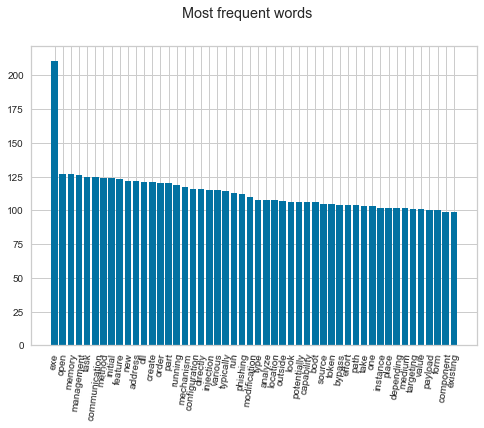

In [7]:
import matplotlib.pyplot as plt

words = [i[0] for i in common_words]
appears = [i[1] for i in common_words]
plt.bar(words, appears)
plt.suptitle('Most frequent words')
plt.xticks(rotation='82.5')

#plt.savefig('freq_words.png', dpi=400)
plt.show()

In [8]:
# initialize tf-idf vectorizer and and transform text
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.15)
X = vectorizer.fit_transform(stem_ls)
pickle.dump(vectorizer, open("vectorizer.pickle", "wb"))

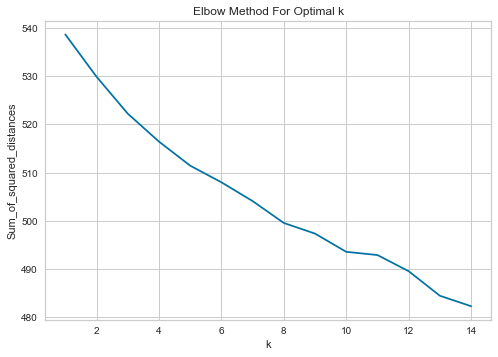

In [9]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
   km = KMeans(n_clusters=k, max_iter=200, n_init=10)
   km = km.fit(X)
   Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [10]:
# train model 
n = 10
model = KMeans(n_clusters=n, init='k-means++', max_iter=100, n_init=1)
model.fit_predict(X)

array([7, 7, 7, 7, 7, 0, 0, 0, 7, 0, 0, 7, 8, 8, 8, 8, 8, 2, 9, 9, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 3, 3, 3, 3, 3, 8, 9, 9, 9, 9, 2, 2,
       2, 3, 2, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 8, 7, 5, 5, 5, 5, 5, 7, 7, 9, 7, 8, 2, 2, 2, 9, 2, 2, 2, 2,
       2, 4, 4, 4, 4, 3, 7, 7, 7, 7, 7, 7, 7, 7, 7, 9, 9, 9, 9, 7, 7, 7,
       7, 7, 2, 7, 7, 7, 7, 7, 7, 3, 3, 3, 2, 2, 2, 2, 2, 3, 3, 3, 3, 2,
       2, 2, 3, 7, 7, 7, 7, 1, 1, 1, 8, 8, 4, 1, 1, 1, 9, 7, 4, 0, 0, 1,
       4, 7, 7, 7, 7, 0, 0, 7, 0, 1, 9, 7, 9, 7, 7, 7, 7, 2, 3, 3, 3, 1,
       1, 1, 1, 1, 7, 4, 4, 4, 7, 7, 7, 7, 7, 2, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 9, 3, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 3, 1, 1, 1, 1, 1, 1,
       7, 3, 8, 7, 7, 7, 7, 1, 0, 0, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 9, 2, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 2, 7, 2, 3, 7, 7, 7, 7, 7, 7, 2, 7, 2, 1,

In [11]:
filename = 'kmeans_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [12]:
centroids = {}
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(n):
    l = []
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :15]:
        print(' %s' % terms[ind])
        l.append(terms[ind])
    centroids['cluster ' + str(i)] = l
    
with open('kmeans-centroids.txt', 'w') as outfile:
    json.dump(centroids, outfile)

Cluster 0:
 token
 signing
 trust
 cooky
 digital
 signature
 session
 cookie
 root
 analyst
 install
 steal
 saml
 value
 policy
Cluster 1:
 exploitation
 exploit
 spearphishing
 link
 vulnerability
 attack
 endpoint
 targeted
 cause
 website
 document
 internal
 attachment
 gain
 repository
Cluster 2:
 injection
 location
 memory
 shell
 scripting
 share
 office
 transfer
 exfiltration
 possibly
 performing
 unusual
 evade
 useful
 type
Cluster 3:
 communication
 analyze
 client
 packet
 port
 significantly
 receives
 uncommon
 channel
 seen
 utilizing
 sending
 birmingham
 flow
 university
Cluster 4:
 medium
 social
 removable
 persona
 phishing
 development
 capability
 site
 lifecycle
 spearphishing
 focused
 prior
 stage
 visibility
 usb
Cluster 5:
 ticket
 hash
 kerberos
 failure
 brute
 sam
 force
 cracking
 controller
 adsecurity
 request
 dcsync
 valid
 golden
 material
Cluster 6:
 initial
 open
 phishing
 reveal
 reconnaissance
 operational
 opportunity
 occurrence
 rate
 es

In [13]:
model = pickle.load(open('kmeans_model.sav', 'rb'))
vectorizer = pickle.load(open('vectorizer.pickle', "rb"))



In [14]:
ids = []
for i in range(0, n):
    ids.append([])

for i, name, desc, det in zip(dfids, dfname, dfdesc, dfdetect):
    toks = preprocessDesc(name+desc+det)
    fullstring = ' '.join(toks)
   
    Y = vectorizer.transform([fullstring])
    prediction = model.predict(Y)
    ids[prediction[0]].append(i)

In [15]:
for n, i in enumerate(ids):
    print("Cluster "+str(n)+ ' has ids:', i)
    

Cluster 0 has ids: ['T1134', 'T1134.002', 'T1134.003', 'T1134.005', 'T1134.001', 'T1587.002', 'T1587.003', 'T1484', 'T1484.002', 'T1482', 'T1606', 'T1606.002', 'T1606.001', 'T1036.001', 'T1588.003', 'T1588.004', 'T1608.003', 'T1528', 'T1539', 'T1553', 'T1553.002', 'T1553.006', 'T1553.004', 'T1553.003', 'T1111', 'T1550.001', 'T1550.004']
Cluster 1 has ids: ['T1213', 'T1213.001', 'T1213.002', 'T1491', 'T1491.002', 'T1491.001', 'T1587.004', 'T1189', 'T1499', 'T1499.003', 'T1499.004', 'T1499.001', 'T1499.002', 'T1190', 'T1203', 'T1212', 'T1211', 'T1068', 'T1210', 'T1187', 'T1534', 'T1498', 'T1498.001', 'T1498.002', 'T1588.005', 'T1588.006', 'T1566', 'T1598.002', 'T1598.003', 'T1566.001', 'T1566.002', 'T1566.003', 'T1608.004', 'T1608.005', 'T1204', 'T1204.002', 'T1204.001']
Cluster 2 has ids: ['T1098', 'T1123', 'T1119', 'T1020', 'T1197', 'T1059', 'T1059.002', 'T1059.007', 'T1059.001', 'T1059.006', 'T1059.004', 'T1059.005', 'T1059.003', 'T1555', 'T1486', 'T1565', 'T1565.003', 'T1565.001', 'T